In [1]:
from imports import *
from cat_plotting_tools import *

In [2]:
# Get the new HST catalogue 
root_dir = '/Users/abarnes/Library/CloudStorage/Dropbox/Projects/Extragalactic/hstha_nebulae_catalogue/'
inputfile = '%s/all/nebulae_catalogue_wassociations_wprops_fixediso_10pc.fits' %root_dir
outputfile = '%s/all/nebulae_catalogue_wassociations_wprops_wpressures_fixediso_10pc.fits' %root_dir

# Read table
table = QTable.read(inputfile)

# **BOLOMETRIC LUMINOSITY**

In [3]:
"""Get SB99 models"""
inputdir = '/Users/abarnes/Library/CloudStorage/Dropbox/Data/Extragalactic/misc/sb99/fiducial/fiducial_6p0linear' 

names_quanta = ['TIME', 'QHI', 'QHIf', 'QHeI', 'QHeIf', 'QHeII', 'QHeIIf', 'logL']
names_power = ['TIME', 'ALLp', 'OBp', 'RSGp', 'LBVp', 'WRp', 'ALLe', 'ALLm', 'OBm', 'RSGm', 'LBVm', 'WRm']
names_yield  = ['TIME', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Mdotwind', 'Mdotsne','Mdotboth', 'Mtot']


t_ewidth = QTable.read('%s/fiducial_6p0linear.ewidth1' %(inputdir), format='ascii', header_start=3, data_start=4)
t_quanta = QTable.read('%s/fiducial_6p0linear.quanta1' %(inputdir), format='ascii', data_start=5, names=names_quanta)
t_power = QTable.read('%s/fiducial_6p0linear.power1' %(inputdir), format='ascii', data_start=5, names=names_power)
t_yield = QTable.read('%s/fiducial_6p0linear.yield1' %(inputdir), format='ascii', data_start=5, names=names_yield)

tmax = 10 *u.Myr
tmin = 0 *u.Myr
time = t_ewidth['TIME']
time.unit = u.yr
time = time.to('Myr')
mask = ((time>tmin) & (time<tmax))
time = time[mask]
Q = t_quanta['QHI'][mask]
Mdot = t_yield['Mdotwind'][mask]
Lmech = t_power['ALLp'][mask]
Lbol = t_quanta['logL'][mask]
LHa = t_ewidth['LUM(H_A)'][mask]
Lfrac_array = 10**(t_quanta['logL'][mask]-t_ewidth['LUM(H_A)'][mask])

age = table['age_association_nuv_32pc']
age.unit = u.Myr 

# Determine the Lbol/LHa ratio for the HST regions...
Lfrac = np.empty(len(age)) *np.nan 
for i in range(len(age)):
    _, id_ = find_nearest(time.value, age.value[i])
    if id_==0:
        continue
    Lfrac[i] = Lfrac_array[id_]
    
table['Lbol/LHa'] = Lfrac *u.dimensionless_unscaled

In [4]:
def get_Lbol(Lha, conv=138):
    return conv*Lha

KE12_conv = 138 # with constant Kennicutt & Evans (2012) - also Lopez et al. (2014)
B21_conv = 88.2 # with constant conversion from Barnes21
low_conv = 17.684 # with lower limit from ionising photons only

Lbol      = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=table['Lbol/LHa'])
Lbol_KE12 = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=KE12_conv) 
Lbol_B21  = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=B21_conv)
Lbol_low  = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=low_conv) 

# table['Lbol'] = Lbol
# table['Lbol_KE12'] = Lbol_KE12
# table['Lbol_B21'] = Lbol_B21
# table['Lbol_low'] = Lbol_low

# Here I choose to only keep the Lbol using a constant conversion as not clear if we can trust ages 
table['Lbol'] = Lbol_B21

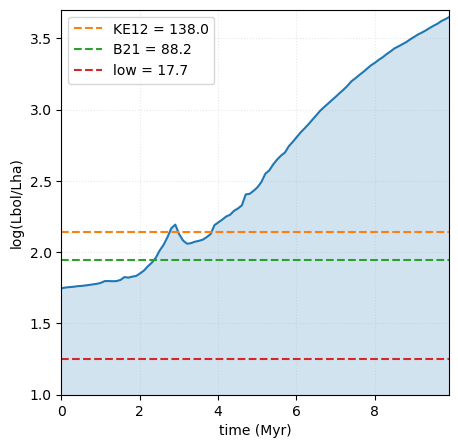

In [5]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

ax.plot(time, np.log10(Lfrac_array))
ax.fill_between(time.value, np.log10(Lfrac_array.value), alpha=0.2)

ax.plot([0,10], np.log10([KE12_conv, KE12_conv]), label='KE12 = %0.1f' %KE12_conv, ls='--')
ax.plot([0,10], np.log10([B21_conv, B21_conv]), label='B21 = %0.1f' %B21_conv, ls='--')
ax.plot([0,10], np.log10([low_conv, low_conv]), label='low = %0.1f' %low_conv, ls='--')

ax.set_xlim([0,9.9])
ax.set_ylim([1,3.7])
ax.set_xlabel('time (Myr)')
ax.set_ylabel('log(Lbol/Lha)')
ax.legend()

ax.grid(alpha=0.3, linestyle=':')

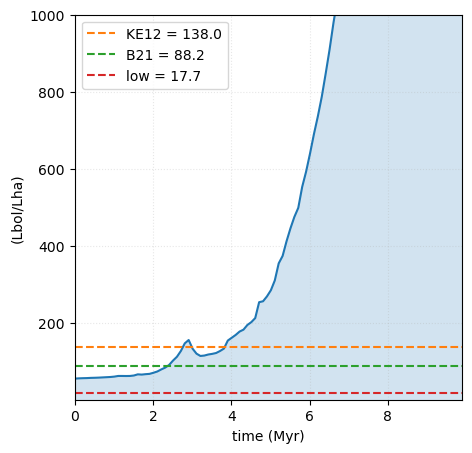

In [6]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

ax.plot(time, Lfrac_array)
ax.fill_between(time.value, Lfrac_array.value, alpha=0.2)

ax.plot([0,10], ([KE12_conv, KE12_conv]), label='KE12 = %0.1f' %KE12_conv, ls='--')
ax.plot([0,10], ([B21_conv, B21_conv]), label='B21 = %0.1f' %B21_conv, ls='--')
ax.plot([0,10], ([low_conv, low_conv]), label='low = %0.1f' %low_conv, ls='--')

ax.set_xlim([0,9.9])
ax.set_ylim([1,1000])
ax.set_xlabel('time (Myr)')
ax.set_ylabel('(Lbol/Lha)')
ax.legend()

ax.grid(alpha=0.3, linestyle=':')

Number of regions with age <= 5 Myr: 2756
Number of regions with age > 5 Myr: 798


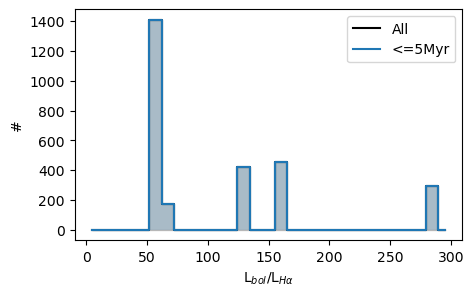

In [7]:
mask_age = age<=5*u.Myr
print(f"Number of regions with age <= 5 Myr: {np.sum(mask_age)}")
print(f"Number of regions with age > 5 Myr: {np.sum(~mask_age)}")

Lfrac_masked = Lfrac[age<=5*u.Myr]

bins = np.linspace(0, 300, 30)
bins1, bins_cent1, hist1 = get_hist(Lfrac, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(Lfrac_masked, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid', c='black', label='All')
ax.plot(bins_cent2, hist2, ds='steps-mid', label='<=5Myr')

ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', color='black')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.set_xlabel("L$_{bol}$/L$_{H\\alpha}$")
ax.set_ylabel("#")
ax.legend()

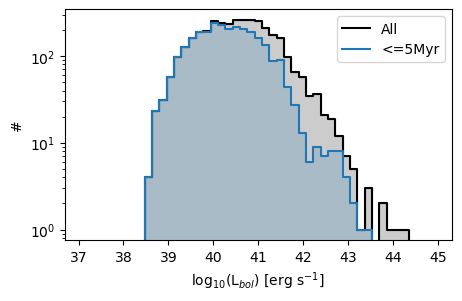

In [8]:
Lbol_masked = Lbol[age<=5*u.Myr]

bins = np.linspace(37,45,50)
bins1, bins_cent1, hist1 = get_hist(np.log10(Lbol.value), bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(np.log10(Lbol_masked.value), bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid', c='black', label='All')
ax.plot(bins_cent2, hist2, ds='steps-mid', label='<=5Myr')

ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', color='black')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.set_yscale('log')

ax.set_xlabel("log$_{10}$(L$_{bol}$) [erg s$^{-1}$]")
ax.set_ylabel("#")
ax.legend()

# **PRESSURES**

**Modules**: Pressure calculations for direct and thermal ionization.

**Pdir**

In [9]:
def get_Pdir(Lbol, r):
    """Taken from Lopez et al. (2014)"""
    Pdir = (3/(4*np.pi)) * (Lbol/(r**2*const.c)) 
    Pdir = Pdir/const.k_B
    return Pdir.to('K/cm^3')

In [10]:
radius_circ_pc  = table['radius_circ_pc']
radius_mom_pc   = table['mean_sigma_pc']
radius_mom_deconv_pc = table['mean_sigma_deconv_pc']
radius_strom_pc = table['radius_strom_pc']

Lbol = table['Lbol']

Pdir_circ  = get_Pdir(Lbol, radius_circ_pc)
Pdir_mom   = get_Pdir(Lbol, radius_mom_pc)
Pdir_mom_deconv = get_Pdir(Lbol, radius_mom_deconv_pc)
Pdir_strom = get_Pdir(Lbol, radius_strom_pc)

# Pdir_circ_Lbol_B21  = get_Pdir(Lbol_B21, radius_circ_pc)
# Pdir_mom_Lbol_B21   = get_Pdir(Lbol_B21, radius_mom_pc)
# Pdir_circ_Lbol_KE12  = get_Pdir(Lbol_KE12, radius_circ_pc)
# Pdir_mom_Lbol_KE12   = get_Pdir(Lbol_KE12, radius_mom_pc)

table['Pdir_circ']  = Pdir_circ
table['Pdir_mom']   = Pdir_mom
table['Pdir_mom_deconv'] = Pdir_mom_deconv
table['Pdir_strom'] = Pdir_strom

# table['Pdir_circ_Lbol_B21']  = Pdir_circ_Lbol_B21
# table['Pdir_mom_Lbol_B21']   = Pdir_mom_Lbol_B21
# table['Pdir_circ_Lbol_KE12']  = Pdir_circ_Lbol_KE12
# table['Pdir_mom_Lbol_KE12']   = Pdir_mom_Lbol_KE12

**Ptherm**

In [11]:
def get_Ptherm(ne, temp, ionisation=2):
    """ionisation=2 assumes single ionised He"""
    Ptherm = const.k_B*ne*temp*ionisation
    Ptherm = Ptherm/const.k_B
    return Ptherm.to('K/cm^3')

In [12]:
ne = table['ne']
t_n2 = table['TEM_NII_MUSE']

Ptherm = get_Ptherm(ne, t_n2)
table['Ptherm'] = Ptherm

In [13]:
table.write(outputfile, overwrite=True)

# **Checks**

In [14]:
print(f"Table length pre-masking: {len(table)}")

table = table[(table['flag_star_MUSE']!=1) & (table['flag_edge_MUSE']!=1) & (table["flag_edge_hst"]!=1)] # remove stars and edge objects

# remove regions with potential problems - manual checked
print(f'Table length pre manual-masking (inc. stars etc): {len(table)}')
print(f'Masked in manual check: {sum(~table['check'].mask)}')
table = table[table['check'].mask]

print(f'Table length post-masking (inc. stars etc): {len(table)}')

# mask hii regions 
mask_hiiregion = table['HII_class_v3_MUSE'] == True
table = table[mask_hiiregion]
print(f"Table length post-masking (HII regions): {len(table)}")

Table length pre-masking: 5467
Table length pre manual-masking (inc. stars etc): 5262
Masked in manual check: 85
Table length post-masking (inc. stars etc): 5177
Table length post-masking (HII regions): 4882


In [15]:
# As we don't use the Lbol conversion, just the constant conversion, we don't need to mask by age... 

# age = table['age_association_nuv_32pc']
# mask_age = np.array(age<=5*u.Myr)
# mask_age_ = np.array(age>5*u.Myr)

# print(f"Number of regions with age <= 5 Myr: {np.sum(mask_age)}")
# print(f"Number of regions with age > 5 Myr: {np.sum(mask_age_)}")

# table = table[mask_age]

In [16]:
print("Number of value in radius_circ_pc: ", np.sum(~np.isnan(table['radius_circ_pc'].data)))
print("Number of value in radius_mom_pc: ", np.sum(~np.isnan(table['mean_sigma_pc'].data)))
print("Number of value in radius_mom_deconv_pc: ", np.sum(~np.isnan(table['mean_sigma_deconv_pc'].data)))
print("Number of value in radius_strom_pc: ", np.sum(~np.isnan(table['radius_strom_pc'].data)))

Number of value in radius_circ_pc:  4882
Number of value in radius_mom_pc:  4882
Number of value in radius_mom_deconv_pc:  4798
Number of value in radius_strom_pc:  2544


In [17]:
# Check number of non values in table for specific columns 
print("Number of values in Pdir_circ: ", np.sum(~np.isnan(table['Pdir_circ'].data)))
print("Number of values in Pdir_mom: ", np.sum(~np.isnan(table['Pdir_mom'].data)))
print("Number of values in Pdir_mom_deconv: ", np.sum(~np.isnan(table['Pdir_mom_deconv'].data)))
print("Number of values in Pdir_strom: ", np.sum(~np.isnan(table['Pdir_strom'].data)))

Number of values in Pdir_circ:  4882
Number of values in Pdir_mom:  4882
Number of values in Pdir_mom_deconv:  4798
Number of values in Pdir_strom:  2544


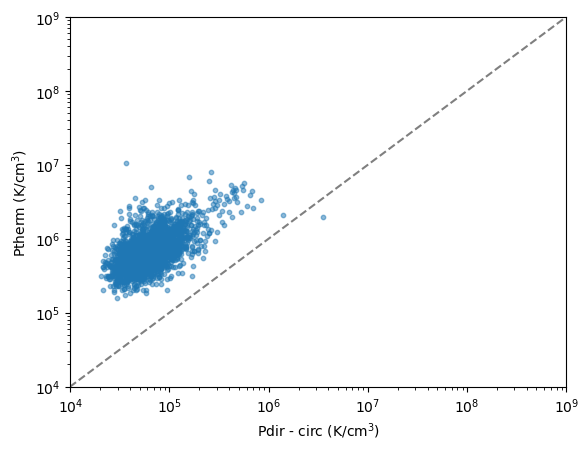

In [18]:
plt.scatter(table['Pdir_circ'], table['Ptherm'], s=10, alpha=0.5)
plt.xlabel('Pdir - circ (K/cm$^3$)')
plt.ylabel('Ptherm (K/cm$^3$)')
plt.plot([1e-2, 1e10], [1e-2, 1e10], ls='--', c='black', alpha=0.5)
plt.xlim([1e4, 1e9])
plt.ylim([1e4, 1e9])
plt.xscale('log')
plt.yscale('log')

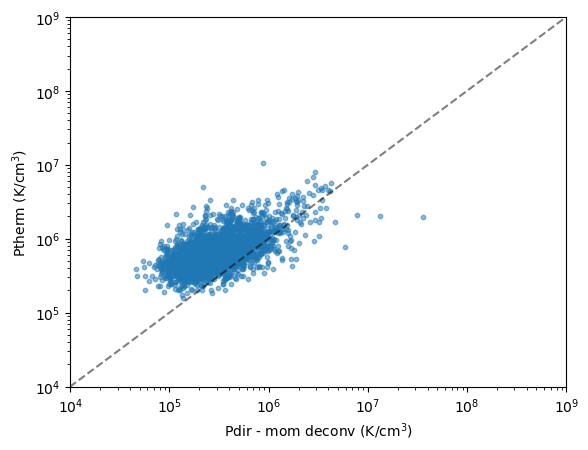

In [19]:
plt.scatter(table['Pdir_mom_deconv'], table['Ptherm'], s=10, alpha=0.5)
plt.xlabel('Pdir - mom deconv (K/cm$^3$)')
plt.ylabel('Ptherm (K/cm$^3$)')
plt.plot([1e-2, 1e10], [1e-2, 1e10], ls='--', c='black', alpha=0.5)
plt.xlim([1e4, 1e9])
plt.ylim([1e4, 1e9])
plt.xscale('log')
plt.yscale('log')